In [1]:
import math
import random
import decimal
import scipy.linalg
import numpy.random as nrand
import matplotlib.pyplot as plt
import gpflow
import numpy as np
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
plt = matplotlib.pyplot

C:\Anaconda\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
C:\Anaconda\lib\site-packages\multipledispatch\dispatcher.py:24: AmbiguityWarning: 
Ambiguities exist in dispatched function _expectation

The following signatures may result in ambiguous behavior:
	[Gaussian, Identity, NoneType, Kernel, InducingPoints], [Gaussian, Linear, NoneType, Sum, InducingPoints]


Consider making the following additions:

@dispatch(Gaussian, Identity, NoneType, Sum, InducingPoints)
def _expectation(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)


In [2]:
def ou_levels(a,b,dt,sigma,time):
    #This method returns the rate levels of a mean-reverting ornstein uhlenbeck process.
    x = np.zeros(len(time))
    for i in range(0, len(time)-1):
        x[i+1]=x[i]+a*(b-x[i])*dt+math.sqrt(dt)*sigma*np.random.normal(0,1)
    return x

In [3]:
dt=0.02
time=np.arange(0,2,dt)# time
sigma=0.3
a=1# the coefficient in front, the rate
b=1.2# the mean

In [4]:
# same data to all different lengthscales !!!!!
training_data=ou_levels(1,b,dt,2,time)
t=time# time vector
x=training_data
t=t[::8]
x=x[::8]
# Setting everything to column vectors
t_column=t.reshape(-1,1)
x_column=x.reshape(-1,1)

In [5]:
def plot(m):
    tt = np.linspace(0, 3, 100).reshape(100, 1)
    mean, var = m.predict_y(tt)
    plt.figure(figsize=(12, 6))
    plt.plot(t_column,x_column, 'kx', mew=2)
    plt.plot(tt, mean, 'C0', lw=2)
    plt.fill_between(tt[:,0],
                     mean[:,0] - 2*np.sqrt(var[:,0]),
                     mean[:,0] + 2*np.sqrt(var[:,0]),
                     color='C0', alpha=0.2)
    plt.xlim(0, 3)

Text(0,0.5,'OU level')

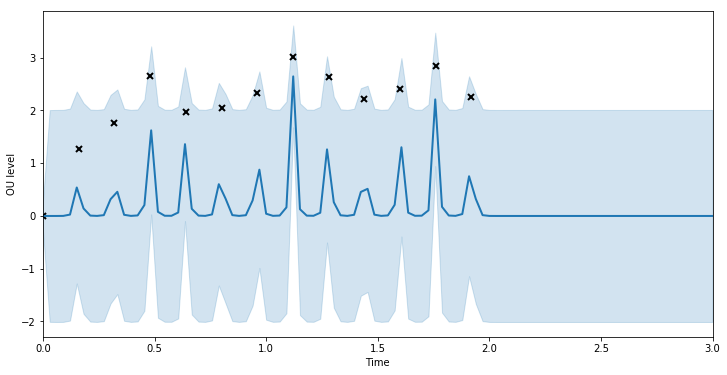

In [6]:
k = gpflow.kernels.Matern12(1,lengthscales=0.01)
m = gpflow.models.GPR(t_column,x_column,kern=k)
m.likelihood.variance = 0.01# observation noise
plot(m)
plt.xlabel('Time')
plt.ylabel('OU level')

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 28.948137
  Number of iterations: 11
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 28.948137
  Number of iterations: 11
  Number of functions evaluations: 13


,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/variance,Parameter,None,+ve,True,(),True,5.0209554341238425
GPR/kern/lengthscales,Parameter,None,+ve,True,(),True,0.010009867429836892
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,0.010432188865419391


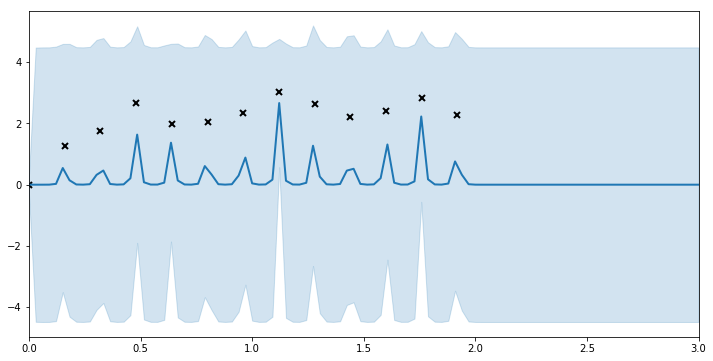

In [7]:
gpflow.train.ScipyOptimizer().minimize(m)
plot(m)
m.as_pandas_table()

In [8]:
# Plotting the marginal likelihood against the parameters
variance_vector=np.linspace(0.01,10,5)
lengthscale_vector=np.linspace(0.1,100,5)

In [9]:
m=[]
for i in range(0,5):
    k=gpflow.kernels.Matern12(1,lengthscales=lengthscale_vector[i],variance=variance_vector[i])
    m.append(gpflow.models.GPR(t_column,x_column,kern=k))
    m[i].likelihood.variance=0

In [10]:
# This computes the marginal log likelihood before optimization
log_likelihoods=np.array([m.compute_log_likelihood() for m in m])
print(log_likelihoods)


[-2244.40153161   -63.65661436   -63.7365468    -63.85455231
   -63.95681338]


Text(0,0.5,'Log Likelihood')

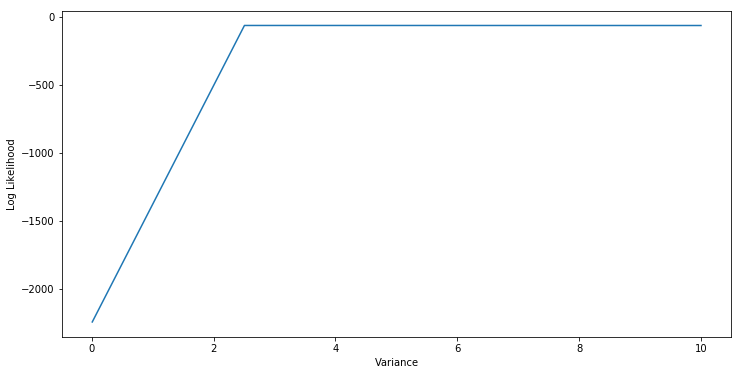

In [11]:
plt.plot(variance_vector,log_likelihoods)
plt.xlabel('Variance')
plt.ylabel('Log Likelihood')

In [12]:
#plt.plot(variance_vector[30:],log_likelihoods[30:])
#plt.xlabel('Variance')
#plt.ylabel('Log Likelihood')

Text(0,0.5,'Log Likelihood')

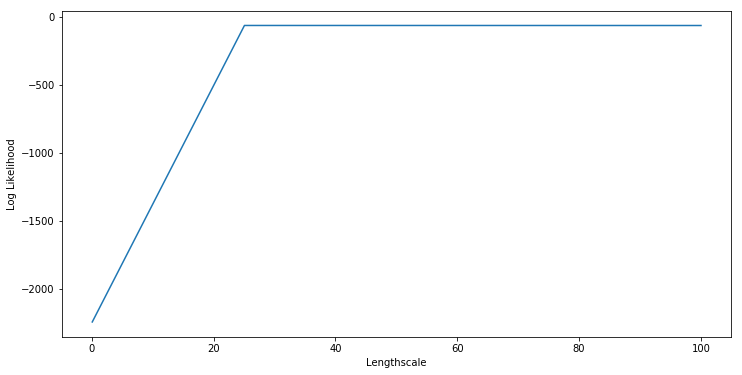

In [13]:
plt.plot(lengthscale_vector,log_likelihoods)
plt.xlabel('Lengthscale')
plt.ylabel('Log Likelihood')

In [14]:
#plt.plot(lengthscale_vector[30:],log_likelihoods[30:])
#plt.xlabel('Lengthscale')
#plt.ylabel('Log Likelihood')

In [15]:
# keeping variance fixed
# Plotting the marginal likelihood against the parameters
variance=1# keeping the variance fixed at 1
lengthscale_vector2=np.linspace(0.1,100,5)

In [16]:
m2=[]
for i in range(0,5):
    k2=gpflow.kernels.Matern12(1,lengthscales=lengthscale_vector2[i],variance=variance)
    m2.append(gpflow.models.GPR(t_column,x_column,kern=k2))
    m2[i].likelihood.variance=0

In [17]:
# This computes the marginal log likelihood before optimization
log_likelihoods2=np.array([m.compute_log_likelihood() for m in m2])
print(log_likelihoods2)


[ -34.3244585  -166.11662014 -340.1683267  -515.90586981 -692.30072725]


Text(0,0.5,'Log Likelihood')

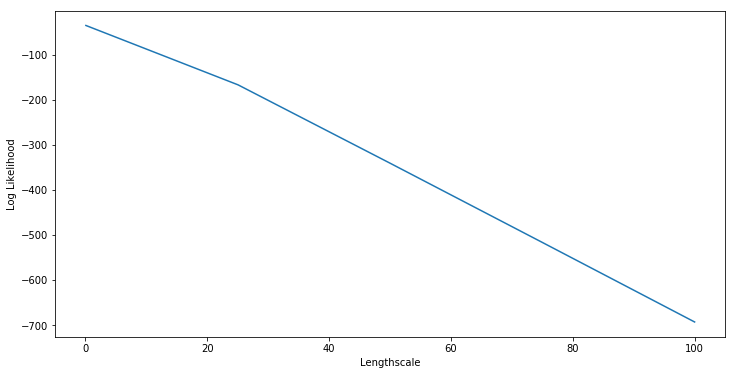

In [18]:
plt.plot(lengthscale_vector2,log_likelihoods2)
plt.xlabel('Lengthscale')
plt.ylabel('Log Likelihood')

In [19]:
#plt.plot(lengthscale_vector2[30:],log_likelihoods2[30:])
#plt.xlabel('Lengthscale')
#plt.ylabel('Log Likelihood')

In [20]:
# keeping the lengthscale fixed at 10
variance_vector3=np.linspace(0.01,10,5)
lengthscale=10

In [21]:
m3=[]
for i in range(0,5):
    k3=gpflow.kernels.Matern12(1,lengthscales=10,variance=variance_vector3[i])
    m3.append(gpflow.models.GPR(t_column,x_column,kern=k3))
    m3[i].likelihood.variance=0

In [22]:
# This computes the marginal log likelihood before optimization
log_likelihoods3=np.array([m.compute_log_likelihood() for m in m3])
print(log_likelihoods3)


[-7212.1735746    -26.25575534   -16.23643064   -14.01738515
   -13.45759414]


Text(0,0.5,'Log Likelihood')

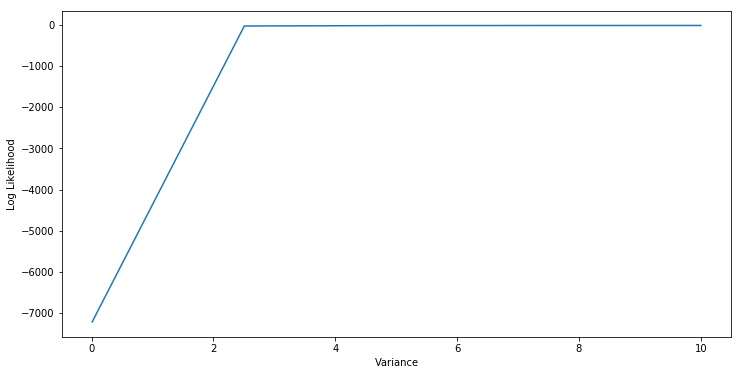

In [23]:
plt.plot(variance_vector3,log_likelihoods3)
plt.xlabel('Variance')
plt.ylabel('Log Likelihood')

In [24]:
#plt.plot(variance_vector3[30:],log_likelihoods3[30:])
#plt.xlabel('Variance')
#plt.ylabel('Log Likelihood')

In [25]:
function FirstDeriv = BlackBoxFirstDeriv_phi(pressure, param_sc, extra_p, l, u)

% Calculates the derivative of the black-box sor06 w.r.t. every parameter 

% input: pressure, param, nd, id

% output: the first derivative for every parameter

sor0 = pressure;

id = extra_p(1); nd = extra_p(2);

FirstDeriv = NaN(nd, numel(sor0)); % chosen first deriv for every parameter

%delete(gcp('nocreate'))
%parpool('local', nd)

parfor i = 1:nd
    
    if i == 1 %f3
        %h = 0.0001;
        h = 1e-6;
        param_sc_hplus = [param_sc(1)+h, param_sc(2), param_sc(3), ...
            param_sc(4)];

    elseif i == 2 % rr1
        %h = 0.0001;
        h = 1e-7;
        param_sc_hplus = [param_sc(1), param_sc(2)+h, param_sc(3), ...
            param_sc(4)];
        
    elseif i == 3 % rr2
        %h = 0.0001;
        h = 1e-6;
        param_sc_hplus = [param_sc(1), param_sc(2), param_sc(3)+h, ...
            param_sc(4)];
        
    else % cc1
        %h = 0.0001;
        h = 1e-7;
        param_sc_hplus = [param_sc(1), param_sc(2), param_sc(3), ...
            param_sc(4)+h];
        
    end
    
    param_hplus = (u.*exp(param_sc_hplus(1:4))+l)./(1+exp(param_sc_hplus(1:4)));
    
    cx = unix(sprintf('./sor06 %f %f %f %f %d', ...
        param_hplus(1), param_hplus(2), param_hplus(3), param_hplus(4), i+9));
    
    if cx == 0
        state = CreateData_Optim(i+9);
        sorh_plus = state(end/2+1:end);
    else
        sorh_plus = repmat(10^10, numel(sor0), 1);
    end
    
    FirstDeriv(i,:) = (sorh_plus - sor0)./h;
    
end


end

SyntaxError: invalid syntax (<ipython-input-25-fbb3bf4e67ee>, line 1)